In [ ]:
#The goal of this TP is to propose a CNN for object classification
#We will use the newdata dataset during this TP
#Note : You should submit the completed notebook file and
#a pdf file describing the different results

# Imports & setups

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
%%capture
!pip install wandb -q

In [10]:
import wandb
wandb.login()

wandb: Currently logged in as: amineremache (use `wandb login --relogin` to force relogin)


True

# Dataset & Dataloader preparation 

In [ ]:
%%capture
!unzip Newdata.zip && mv Newdata/Test/Shape1/ Newdata/Test/Cow/ && mv Newdata/Test/Shape2/ Newdata/Test/Horse/

In [3]:
BATCH_SIZE = 4

data_transforms = {
    'Train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = ImageFolder('/content/Newdata/Train',data_transforms['Train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testset = ImageFolder('/content/Newdata/Test',data_transforms['Test'])
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
CLASS_NAMES = ('Cow', 'Horse')

# Data vizualization

In [4]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(4):
      ax = plt.subplot(5,5,n+1)
      img = image_batch[n] / 2 + 0.5     # unnormalize
      img = img.numpy()
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


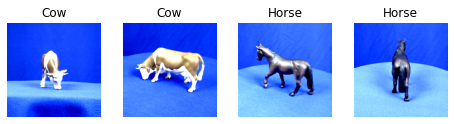

In [5]:
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

# Building the model

In [6]:
#From scratch design a shallow CNN composed of a set of conv, pool and FC layers

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#Train the model
#Plot the error vs epoch curve
#Report the accuracy on the test set

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch, steps_per_epoch=20):
  model.train()

  train_loss = 0
  train_total = 0
  train_correct = 0

  for batch_idx, (data, target) in enumerate(train_loader, start=0):
    
    data, target = data.to(device), target.to(device)
    
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = criterion(output, target)
    train_loss += loss.item()

    scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += int(sum(predictions == target))
            
    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()

  acc = round((train_correct / train_total) * 100, 2)
  print('Epoch [{}], Loss: {}, Accuracy: {}'.format(epoch, train_loss/train_total, acc), end='')
  wandb.log({'Train Loss': train_loss/train_total, 'Train Accuracy': acc, 'Epoch': epoch})

In [8]:
def test(model, device, test_loader, criterion, epoch, classes):
  model.eval()

  test_loss = 0
  test_total = 0
  test_correct = 0

  example_images = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()
          
          scores, predictions = torch.max(output.data, 1)
          test_total += target.size(0)
          test_correct += int(sum(predictions == target))

  acc = round((test_correct / test_total) * 100, 2)
  print(' Test_loss: {}, Test_accuracy: {}'.format(test_loss/test_total, acc))
  wandb.log({'Test Loss': test_loss/test_total, 'Test Accuracy': acc, 'Epoch': epoch})

In [11]:
net = MyNet().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

wandb.init(project="tp_cvai", entity="amineremache")
wandb.watch(net, log='all')

for epoch in range(1,11):
  train(net, device, trainloader, optimizer, criterion, epoch)
  test(net, device, testloader, criterion, epoch, CLASS_NAMES)

print('Finished Training')

MyNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


Epoch [1], Loss: 0.09742051779673003, Accuracy: 79.27 Test_loss: 1.342318834868709, Test_accuracy: 47.56
Epoch [2], Loss: 0.0012454407924735516, Accuracy: 100.0 Test_loss: 1.7893252903822683, Test_accuracy: 56.1
Epoch [3], Loss: 0.07420612577444322, Accuracy: 97.56 Test_loss: 2.2546290837717233, Test_accuracy: 54.88
Epoch [4], Loss: 1.2315200786088168e-06, Accuracy: 100.0 Test_loss: 1.7476923366520987, Test_accuracy: 56.1
Epoch [5], Loss: 1.8516730924285453e-06, Accuracy: 100.0 Test_loss: 1.7968132591001718, Test_accuracy: 56.1
Epoch [6], Loss: 4.531854465028573e-07, Accuracy: 100.0 Test_loss: 1.905437703714619, Test_accuracy: 56.1
Epoch [7], Loss: 5.1972251889665354e-08, Accuracy: 100.0 Test_loss: 1.919474459651699, Test_accuracy: 56.1
Epoch [8], Loss: 6.105830938954652e-08, Accuracy: 100.0 Test_loss: 1.9214592201188436, Test_accuracy: 56.1
Epoch [9], Loss: 4.870127436288801e-08, Accuracy: 100.0 Test_loss: 1.9215058556893139, Test_accuracy: 56.1
Epoch [10], Loss: 4.797439087723649e-08

# Pre-trained model

In [12]:
#Load in pre-trained weights from a network trained on a large dataset

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True) # vgg16 trained on ImageNet-1000
resnet = models.resnet18(pretrained=True) # resnet trained on ImageNet-1000

In [13]:
#Extract features from the train and test images using the pre-trained model
#model = vgg16
#model.fc = nn.Linear(4096, 2)
model = resnet
model.fc = nn.Linear(512, 2)
model.cuda()

net2 = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters())

test(net2, device, testloader, criterion, 1, CLASS_NAMES)

 Test_loss: 0.15864890268663082, Test_accuracy: 70.73


# 1-Nearst Neighbour classifier

In [14]:
#Classify the test images using a 1-nearst neighbour classifier

import numpy as np
from keras.preprocessing import image
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
print("Files imported successfully")
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)


def load_image_files(container_path, dimension=(224, 224)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]
    images = []
    flat_data = []
    target = []
    count = 0
    train_img = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            img = imread(file)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img_pred = cv.resize(img, (50, 50), interpolation=cv.INTER_AREA)
            img_pred = image.img_to_array(img_pred)
            img_pred = img_pred / 255
            train_img.append(img_pred)
    X = np.array(train_img)
    return X

X = []
X = load_image_files("/content/Newdata_merged")

y0 = np.zeros(82)
y1 = np.ones(82)
y = []
y = np.concatenate((y0,y1), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.5)

from builtins import range
from builtins import object

num_training = X_train.shape[0]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = X_test.shape[0]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

num_val = X_val.shape[0]
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

class KNearestNeighbor(object):
    def __init__(self):
        pass

    def predict_label(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][0:k]
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        dists = self.compute_distances_no_loops(X)
        return self.predict_labels(dists, k=k)

    def compute_distances_no_loops(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        dists = np.sqrt((X ** 2).sum(axis=1, keepdims=1) + (self.X_train ** 2).sum(axis=1) - 2 * X.dot(self.X_train.T))
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][0:k]
            closest_y = closest_y.astype(int)
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

print("Accuracy for k=1")
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances_no_loops(X_val)
y_val_pred = classifier.predict_labels(dists, k=1)
num_correct = np.sum(y_val_pred == y_val)
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

Files imported successfully
Accuracy for k=1
Got 15 / 16 correct => accuracy: 0.937500


# Freeze weights on convolutional layers

In [15]:
#Load in pre-trained weights from a network trained on a large dataset
#Freeze all the weights in the convolutional layers
model=vgg16
for param in model.parameters():
    param.requires_grad = False

In [16]:
#Replace the FC layers of the network with a custom classifier

model.classifier[6] = torch.nn.Sequential(
                      torch.nn.Linear(4096, 256), 
                      torch.nn.ReLU(), 
                      torch.nn.Dropout(0.4),
                      torch.nn.Linear(256, 2),                   
                      torch.nn.LogSoftmax(dim=1))


In [17]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


In [18]:
# Move to gpu
model = model.to('cuda')
# Distribute across 2 gpus
model = nn.DataParallel(model)

In [91]:
#Train only the FC layers for the object classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

wandb.init(project="tp_cvai", entity="amineremache")
wandb.watch(net, log='all')

for epoch in range(1,11):
  train(model, device, trainloader, optimizer, criterion, epoch)
  test(model, device, testloader, criterion, epoch, CLASS_NAMES)

Epoch [1], Loss: 0.03996407306977389, Accuracy: 90.24 Test_loss: 0.16797634513355528, Test_accuracy: 69.51
Epoch [2], Loss: 0.00032294223681552335, Accuracy: 100.0 Test_loss: 0.11599016749233869, Test_accuracy: 81.71
Epoch [3], Loss: 0.0004160762673895898, Accuracy: 100.0 Test_loss: 0.10692685566577782, Test_accuracy: 81.71
Epoch [4], Loss: 7.169364498032935e-05, Accuracy: 100.0 Test_loss: 0.11530913664106132, Test_accuracy: 81.71
Epoch [5], Loss: 1.7466804728393536e-05, Accuracy: 100.0 Test_loss: 0.1281593883826778, Test_accuracy: 80.49
Epoch [6], Loss: 3.1896402469716184e-06, Accuracy: 100.0 Test_loss: 0.10639597664277706, Test_accuracy: 82.93
Epoch [7], Loss: 2.2464589032133186e-06, Accuracy: 100.0 Test_loss: 0.10746830579219244, Test_accuracy: 82.93
Epoch [8], Loss: 8.413501087151245e-07, Accuracy: 100.0 Test_loss: 0.1094052735020452, Test_accuracy: 82.93
Epoch [9], Loss: 4.6569697766290915e-05, Accuracy: 100.0 Test_loss: 0.1130421565740551, Test_accuracy: 81.71
Epoch [10], Loss: 3

# Trying different optimizers

In [20]:
#Try different optimizers for the training

criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD, optim.Adadelta, optim.ASGD, optim.Adam]

for optimizer in optimizers:
  print("optimizer used for this training is : ",optimizer)
  optimizer = optimizer(model.parameters(),lr=0.01)
  for epoch in range(1,11):
    train(model, device, trainloader, optimizer, criterion, epoch)
    test(model, device, testloader, criterion, epoch, CLASS_NAMES)

optimizer used for this training is :  <class 'torch.optim.sgd.SGD'>
Epoch [1], Loss: 0.07276152937514026, Accuracy: 92.68 Test_loss: 0.12550474994066285, Test_accuracy: 78.05
Epoch [2], Loss: 0.023307438803518692, Accuracy: 97.56 Test_loss: 0.09910344005357928, Test_accuracy: 82.93
Epoch [3], Loss: 0.00885908798564498, Accuracy: 100.0 Test_loss: 0.09506064762429493, Test_accuracy: 81.71
Epoch [4], Loss: 0.007358124502366636, Accuracy: 100.0 Test_loss: 0.08753135714043932, Test_accuracy: 86.59
Epoch [5], Loss: 0.004396107656137291, Accuracy: 100.0 Test_loss: 0.0891440687928258, Test_accuracy: 84.15
Epoch [6], Loss: 0.0049324168130846285, Accuracy: 100.0 Test_loss: 0.08712191616253155, Test_accuracy: 84.15
Epoch [7], Loss: 0.004875546193499936, Accuracy: 100.0 Test_loss: 0.10188374295830727, Test_accuracy: 81.71
Epoch [8], Loss: 0.004386309591099256, Accuracy: 100.0 Test_loss: 0.09302827016246028, Test_accuracy: 81.71
Epoch [9], Loss: 0.003978639690236688, Accuracy: 100.0 Test_loss: 0.0